


# ***Click Prediction***

----

# Abstract

In online advertising, predicting whether a user will click on an ad is crucial for optimizing ad placement and maximizing revenue. In this project, we propose a novel approach to click prediction using Convolutional Neural Networks (CNNs). We use three datasets: the groundtruth dataset containing information about ad clicks, the participants dataset containing information about ad characteristics and user interactions, and the user behavior dataset containing detailed user interactions on a webpage. By merging these datasets, we create a comprehensive dataset for training our CNN model.

We preprocess the data and reshape it to fit the CNN input shape. We then build and train a CNN model using Keras with TensorFlow backend. The model learns to extract relevant features from the user behavior data and predicts whether a user will click on an ad. We evaluate the model using standard classification metrics such as accuracy, precision, recall, and F1-score.

Our experimental results demonstrate that the proposed CNN model outperforms traditional machine learning models for click prediction. The model's ability to learn from raw user behavior data makes it a promising approach for click prediction in online advertising.

# Table of Contents

1. Data Collection
    1. Groundtruth Dataset
    2. Participants Dataset
    3. User Behavior Dataset
        - Extract width and height of web page
        - Load CSV file into pandas dataframe
        - Extract Time Spent And Date
        - Temporal Features
        - Maximum Time Spent
        - Extract CSV data consist of User Behavior

2. Data Preprocessing
    1. Merge Data frames
    2. Country Parameter
    3. Category Parameter
    4. Convert Categorical Values To Numeral Values
    5. Check For Missing Values
    6. Filter Data Based On Time Spent
    7. Check Value Count Ad Click

3. Feature Selection
    1. Remove Unnecessary Columns
    2. Correlation Between Features
    3. Correlation Between Features And Target
    4. Mutual Information

4. Machine Learning
    1. Functions
        - Confusion plot function
        - AUC curve plot function

    2. One Hot Encoding
    3. Handling Imbalanced Data
    4. Data Train/Test Split
    5. Data Scaling
    6. Naive Bayes
    7. Random Forest Classifier
    8. Logistic Regression Model
    9. Support Vector Regression (SVR) 
    10. Convolutional Neural Network Model
        - Plot Learning Curve

5. Evaluation

6. Visualizing User Behavior Data

7. Conclusion

8. Refrences

----
# 1. Data Collection
## 1.1 Groundtruth Dataset

This dataset contains information about ad clicks. It includes whether a user clicked on an ad or not (ad_clicked) and a unique identifier for each log entry (log_id).

Based on the definition of the project, a series of data cannot be used in the project. We will remove them at this initial stage, although some of them could have effective parameters in the prediction.

***Parameters :***
- `ad_clicked`: (int) Whether the participant clicked on the ad (1) or not (0).
- `log_id`: (string) Mouse tracking log ID.


In [191]:
# Read the dataframe in pandas format
import pandas as pd

groundtruth = pd.read_csv("groundtruth.tsv", delimiter="\t")
groundtruth = groundtruth.drop(["attention","user_id"], axis=1)
groundtruth.head(3) 

,ad_clicked,log_id
0,0,20181002033126
1,1,20181001211223
2,0,20181001170952


## 1.2 Participants Dataset
This dataset contains information about ad characteristics and user interactions. It includes details such as the country of the participant (country), ad position (ad_position), ad type (ad_type), ad category (ad_category), SERP (Search Engine Results Page) ID (serp_id), search query (query), and a unique identifier for each log entry (log_id).

***Parameters***
- `country`: (string) Participant's country, in ISO-3 format.

- `ad_position`: (string) Ad stimulus position.

- `ad_type`: (string) Ad stimulus type.

- `ad_category`: (string) Ad stimulus category.

- `serp_id`: (string) Ad SERP identifier.

- `query`: (string) Ad stimulus query.

- `log_id`: (string) Mouse tracking log ID.

In [192]:
participants = pd.read_csv("participants.tsv", delimiter="\t")
participants = participants.drop(["user_id","education","age","income","gender"], axis=1)
participants.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id
0,PHL,top-left,dd,Computers & Electronics,tablets,tablets,20181002033126
1,VEN,top-right,dd,Shop - Luxury Goods,casio-watches,casio watches,20181001211223
2,VEN,top-left,native,Shop - Luxury Goods,chivas-regal,chivas regal,20181001170952


## 1.3 User Behavior Dataset
This dataset contains detailed user interactions on a webpage. It includes information such as cursor timestamp (cursor), timestamp (timestamp), cursor position (xpos and ypos), event type (event), XPath of the element (xpath), attributes of the element (attrs), and extra information about the event (extras). The unique identifier for each log entry is the name of the file (log_id).

We store this information in the log folder in the ‍‍`user_behavior` data frame.

- ### `Extract width and height of web page`

In the XML file, there is information about the width and length of the document, which we need for normalization. On the other hand, it is better to include this parameter to make each point similar.

In [193]:
import xml.etree.ElementTree as ET

user_behavior = pd.DataFrame(participants["log_id"])

user_behavior["doc_width"] = 0
user_behavior["doc_height"] = 0

for index,row in user_behavior.iterrows():
    tree = ET.parse(f"logs/{row['log_id']}.xml")
    root = tree.getroot()

    doc_w, doc_h = root.find("document").text.split("x")
    scr_w, scr_h = root.find("screen").text.split("x")
    user_behavior.at[index,"doc_width"] = max(int(doc_w),int(scr_w))
    user_behavior.at[index,"doc_height"] = max(int(doc_h),int(scr_h))    

user_behavior.head(3)

,log_id,doc_width,doc_height
0,20181002033126,1366,2064
1,20181001211223,1366,1611
2,20181001170952,1366,2284


- ### `Load CSV File Into DataFrame`

Since we need this information in several steps, we load and store it in a variable.



In [194]:
import os
log_csv_df = {}

for index,row in user_behavior.iterrows():
    file_path = f"logs/{row['log_id']}.csv"
    if not os.path.exists(file_path):
        continue    
    log_csv_df[row['log_id']] = pd.read_csv(file_path, delimiter=" ")

- ### `Extract Time Spent And Date`

One of the important parameters in log files is the time spent on pages. This parameter is not only useful for filtering data, but it can also be used as a prediction parameter.

- ‍‍‍‍`time_spent` : Since the given time is in milliseconds, we divide it by thousands.
- `date` : The Unix Epoch date format is a single number value, representing the number of seconds that have elapsed since 1/1/1970. This is not compatible with Boomi date masking, so converting to and from this date format requires a small script.

In [195]:
user_behavior["time_spent"] = 0
user_behavior["date"] = 0

for index,row in user_behavior.iterrows():
    df2 = log_csv_df[row['log_id']]
    time_spent = df2["timestamp"].iloc[-1] - df2["timestamp"].iloc[0]

    user_behavior.at[index,"time_spent"] = int(time_spent/1000)
    user_behavior.at[index,"date"] = df2["timestamp"].iloc[0]

user_behavior.head(3)

,log_id,doc_width,doc_height,time_spent,date
0,20181002033126,1366,2064,96,1538444060776
1,20181001211223,1366,1611,18,1538421318262
2,20181001170952,1366,2284,54,1538406739854


- ### `Temporal Features`
Time-related features such as `time of day` and `day of week` can provide valuable insights into when users are most likely to click on ads. These features are typically one-hot encoded to capture their cyclic nature.

In [196]:
import time

user_behavior["week_day"] = 0
user_behavior["hour"] = 0

for index,row in user_behavior.iterrows():
    epoch = int(row["date"]) / 1000
    user_behavior.at[index,"week_day"] = time.gmtime(epoch).tm_wday
    user_behavior.at[index,"hour"] = time.gmtime(epoch).tm_hour

user_behavior.head(3)

,log_id,doc_width,doc_height,time_spent,date,week_day,hour
0,20181002033126,1366,2064,96,1538444060776,1,1
1,20181001211223,1366,1611,18,1538421318262,0,19
2,20181001170952,1366,2284,54,1538406739854,0,15


- ### `Maximum Time Spent`

In [197]:
max_time_spent = max(user_behavior["time_spent"])
max_time_spent

5356927

- ### `Extract CSV Data Consist Of User Behavior`

In this step, we modeled the user's behavior such as clicking into a two-dimensional array.

We are faced with six different event models, including ‍`click` , `mouseup`, `mouseover`, `mousedown`, `mousemove`, `contextmenu`, `scroll` which we have tested four types to record as effective data.

In [198]:
import numpy as np

event = {"click":1, "mouseup":2, "mouseover":3, "mousedown":4}
w = 10
h = 10
matrix1 = []

for index1,row1 in user_behavior.iterrows():

    matrix_event = np.array([[(0,0) for x in range(w)] for y in range(h)])

    df2 = log_csv_df[row1['log_id']]
    start_time = df2.at[0,"timestamp"]

    for index, row in df2.iterrows():
        xpos = (int(row["xpos"])/row1["doc_width"]) * w
        xpos = min(w-1,int(xpos))

        ypos = (int(row["ypos"])/row1["doc_height"]) * h
        ypos = min(h-1,int(ypos))

        event_type = event.get(row["event"]) or 0 
        event_time = int((row["timestamp"] - start_time)/1000)
        # event type: click, mouseup, mouseover, mousedown     event time
        matrix_event[xpos][ypos] = (event_type,  event_time)


    matrix_event = matrix_event.flatten()
    matrix1.append(matrix_event)


# dimension of matrix
dim = len(matrix1[0])
matrix1 = pd.DataFrame(matrix1, columns=[f"event{i}" for i in range(dim)])


user_dataset = pd.concat([user_behavior, matrix1], axis=1)

user_dataset.head(3)

,log_id,doc_width,doc_height,time_spent,date,week_day,hour,event0,event1,event2,...,event190,event191,event192,event193,event194,event195,event196,event197,event198,event199
0,20181002033126,1366,2064,96,1538444060776,1,1,0,96,0,...,0,0,0,0,0,0,0,0,0,0
1,20181001211223,1366,1611,18,1538421318262,0,19,0,18,0,...,0,0,0,0,0,0,0,0,0,0
2,20181001170952,1366,2284,54,1538406739854,0,15,0,54,0,...,0,0,0,0,0,0,0,0,0,0


----
# 2. Data Preprocessing

Data preprocessing is a crucial step in machine learning projects, as it involves transforming raw data into a format that is suitable for modeling. The quality and structure of the data greatly influence the performance of the machine learning models.

## 2.1 Merge Data frames

Merging two dataframes is a fundamental operation in data manipulation, allowing you to combine data from different sources based on common columns. In Python, you can achieve this using the merge() function provided by the Pandas library. 

In [199]:
dataset = participants.merge(groundtruth, on="log_id", how="inner")
dataset = dataset.merge(user_dataset, on="log_id", how="inner")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Columns: 214 entries, country to event199
dtypes: int64(208), object(6)
memory usage: 4.7+ MB


## 2.2 Country Parameter

In this code snippet, I aimed to address the issue of low-value countries in the dataset. Here's what I did:

 I identified the countries with low occurrences in the dataset. To do this, I counted the occurrences of each country using the value_counts() function and stored the indices of countries with fewer than 50 occurrences in the low_value_countries variable.

After that, I replaced the low-value country names with "OTHER" in the DataFrame to combine them. I accomplished this using boolean indexing to locate the rows where the country was one of the low-value countries and then replacing those country names with "Other".

This preprocessing step ensures that countries with sparse data are combined into a single category, simplifying the dataset and making it easier to analyze.

In [200]:
dataset["country"].value_counts()

country
USA    1768
VEN     368
GBR     209
CAN      77
EGY      38
       ... 
BOL       1
DNK       1
MYS       1
KWT       1
HUN       1
Name: count, Length: 69, dtype: int64

In [201]:
temp = dataset["country"].value_counts()
low_rep = temp[temp < 50].index
dataset["country"] = dataset["country"].replace(low_rep, "OTHER")
dataset["country"].value_counts()

country
USA      1768
OTHER     487
VEN       368
GBR       209
CAN        77
Name: count, dtype: int64

country
USA      1768
OTHER     487
VEN       368
GBR       209
CAN        77
Name: count, dtype: int64

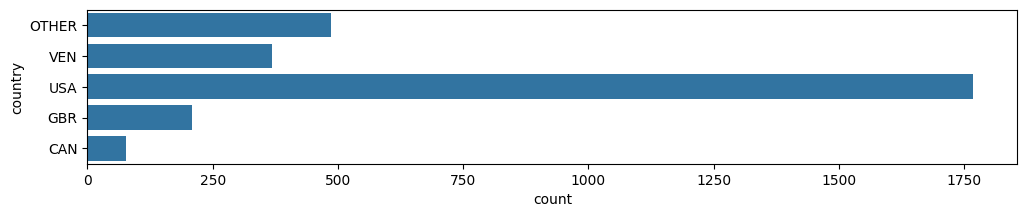

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,2))
sns.countplot(y ="country", data = dataset)
dataset["country"].value_counts()

<Axes: xlabel='country'>

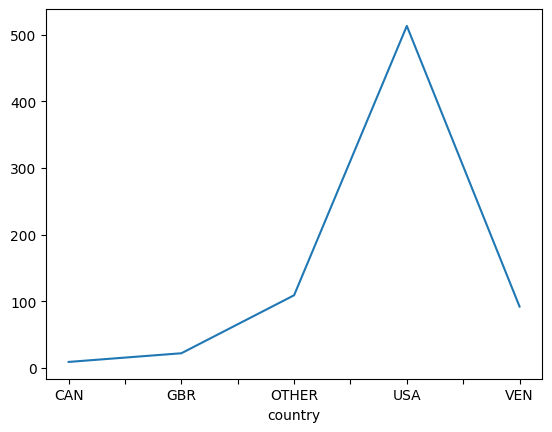

In [203]:
dataset["country"][dataset["ad_clicked"] == 1].value_counts().sort_index().plot()

## 2.3 Category Parameter

Just like the country classification, the categories with low values were combined with each other. We did the same here.

In [204]:
dataset["ad_category"].value_counts()

ad_category
Computers & Electronics           805
Shop - Apparel                    479
Shop - Luxury Goods               440
Travel                            231
Shop - Sporting Goods             213
Shop - Photo & Video Services     207
Shop - Toys                       126
Games                             110
Shop - Wholesalers & Liquidatr     87
Shop - Event Ticket Sales          76
Autos & Vehicles                   62
Shop - Gifts & Special Event       38
Food & Drink                       18
Real Estate                        17
Name: count, dtype: int64

In [205]:
temp = dataset["ad_category"].value_counts()
low_rep = temp[temp < 100].index
dataset["ad_category"] = dataset["ad_category"].replace(low_rep, "OTHER")
dataset["ad_category"].value_counts()

ad_category
Computers & Electronics          805
Shop - Apparel                   479
Shop - Luxury Goods              440
OTHER                            298
Travel                           231
Shop - Sporting Goods            213
Shop - Photo & Video Services    207
Shop - Toys                      126
Games                            110
Name: count, dtype: int64

ad_category
Computers & Electronics          805
Shop - Apparel                   479
Shop - Luxury Goods              440
OTHER                            298
Travel                           231
Shop - Sporting Goods            213
Shop - Photo & Video Services    207
Shop - Toys                      126
Games                            110
Name: count, dtype: int64

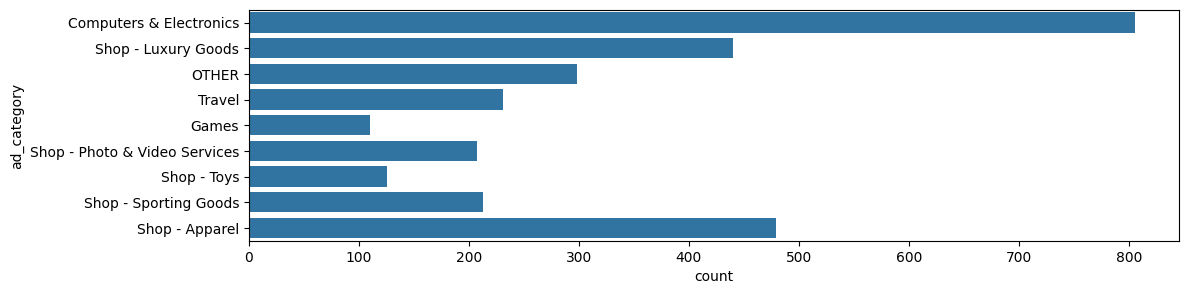

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,3))
sns.countplot(y ="ad_category", data = dataset)
dataset["ad_category"].value_counts()

## 2.4 Convert Categorical Values To Numeral Values
To convert categorical values to numerical values, we can use techniques like Label Encoding.

In [207]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

categories = ["query", "country", "ad_type", "ad_position", "ad_category", "serp_id"]

for cat_name in categories:
    dataset[cat_name] = label_encoder.fit_transform(dataset[cat_name])

## 2.5 Check For Missing Values

In data analysis, null values represent missing or undefined data. Dealing with null values is crucial because they can impact the accuracy and reliability of your analysis.

Handling null values correctly is essential for accurate analysis and modeling.

Fortunately, we don't have an null values in the data and it can remain unchanged.

In [208]:
# Count the number of null values in each feature
num_null_value = dataset.isnull().sum()

# Determine the number of unique values in each feature
num_unique_value = dataset.nunique()

# Create a summary dataframe combining null and unique value counts
df_summary = pd.concat([num_null_value,num_unique_value], axis='columns', keys= ['num of nulls', 'num of unique'])
df_summary[:7]

,num of nulls,num of unique
country,0,5
ad_position,0,2
ad_type,0,2
ad_category,0,9
serp_id,0,63
query,0,55
log_id,0,2909


## 2.6 Filter Data Based On Time Spent
To filter users who spent less than 5 seconds on the website, we can use the timestamp and cursor timestamp columns in the user behavior dataset. We'll calculate the time spent by each user on the website and filter out users who spent less than 5 seconds.

In [209]:
dataset = dataset[dataset["time_spent"] > 5]
dataset = dataset.reset_index(drop=True)
dataset.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id,ad_clicked,doc_width,doc_height,...,event190,event191,event192,event193,event194,event195,event196,event197,event198,event199
0,2,0,0,0,61,53,20181002033126,0,1366,2064,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,4,15,14,20181001211223,1,1366,1611,...,0,0,0,0,0,0,0,0,0,0
2,4,0,1,4,16,15,20181001170952,0,1366,2284,...,0,0,0,0,0,0,0,0,0,0


## 2.7 Check Value Count Ad Click

the class imbalance in the `ad_clicked` data could potentially affect the model's performance. With 1861 rows labeled as 0 and only 557 rows labeled as 1, the model may become biased toward predicting the majority class (0).

ad_clicked
0    1861
1     557
Name: count, dtype: int64

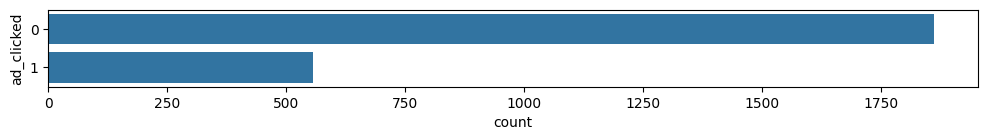

In [210]:
fig = plt.figure(figsize = (12,1))
sns.countplot(y ="ad_clicked", data = dataset)
dataset["ad_clicked"].value_counts()

----
# 3. Feature Selection

Feature Selection is the process of selecting a subset of relevant features for use in machine learning model building.

It is not always the truth that the more data, the better the result will be. Including irrelevant features (the ones that are just unhelpful to the prediction) and redundant features (irrelevant in the presence of others) will only make the learning process overwhelmed and easy to cause overfitting.

By reducing the number of features, we can improve the performance of the machine learning models, while reducing training time and creating more interpretable machine learning models.

## 3.1 Remove Unnecessary Columns

In this step, we preprocess the datasets to remove unnecessary features and prepare them for further analysis.

In [211]:

dataset_final = dataset.drop(["doc_width", "doc_height", "log_id"], axis=1)
len(dataset_final.columns)

211

## 3.2 Correlation Between Features
A correlation coefficient of 1 indicates a perfect positive linear relationship between two variables. In other words, when one variable increases, the other variable also increases proportionally.

,ad_clicked,country,ad_position,ad_type,ad_category,serp_id,query,time_spent,week_day,hour
ad_clicked,1.000000,0.093932,-0.177069,0.069452,-0.063096,0.056782,0.060100,0.037232,-0.011474,-0.001041
country,0.093932,1.000000,0.002907,0.004842,0.024643,0.002144,0.004591,0.006500,-0.134246,0.017579
ad_position,-0.177069,0.002907,1.000000,-0.487027,0.243832,-0.258858,-0.258887,-0.014017,-0.033001,0.029131
ad_type,0.069452,0.004842,-0.487027,1.000000,0.167319,-0.060023,-0.062236,0.028772,0.009073,0.045971
ad_category,-0.063096,0.024643,0.243832,0.167319,1.000000,-0.407683,-0.418692,-0.000238,-0.030711,0.059191
serp_id,0.056782,0.002144,-0.258858,-0.060023,-0.407683,1.000000,0.997231,0.016445,0.035811,-0.001528
query,0.060100,0.004591,-0.258887,-0.062236,-0.418692,0.997231,1.000000,0.016892,0.035628,-0.000571
time_spent,0.037232,0.006500,-0.014017,0.028772,-0.000238,0.016445,0.016892,1.000000,-0.001437,0.016220
week_day,-0.011474,-0.134246,-0.033001,0.009073,-0.030711,0.035811,0.035628,-0.001437,1.000000,-0.106229
hour,-0.001041,0.017579,0.029131,0.045971,0.059191,-0.001528,-0.000571,0.016220,-0.106229,1.000000


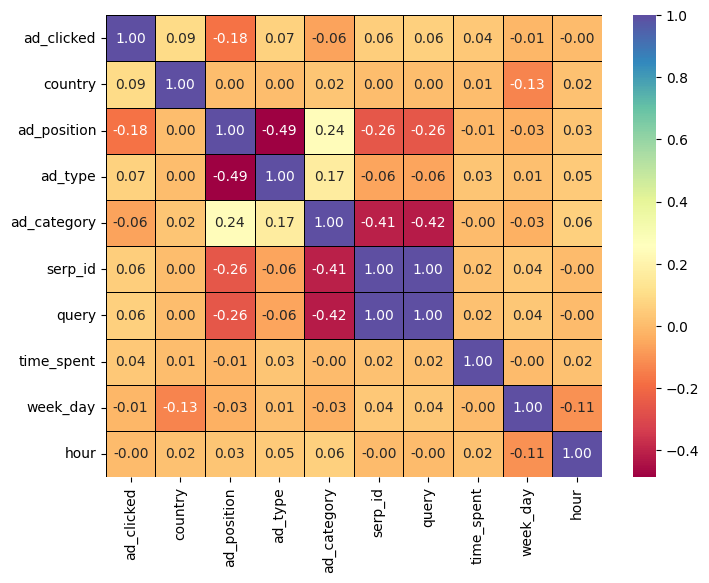

In [212]:
# pip3 install matplotlib
import matplotlib.pyplot as plt
# pip3 install seaborn
import seaborn as sns

# Create correlation matrix for features
features_df = dataset_final[["ad_clicked", "country", "ad_position", "ad_type", "ad_category", "serp_id", "query", "time_spent", "week_day", "hour"]]
feature_corr = features_df.corr(numeric_only=True)

# Display correlation matrix
display(feature_corr)

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, annot=True, fmt='0.2f', linewidths=0.5, linecolor='Black', cmap='Spectral')
plt.show()

Having two parameters with a correlation of 1 can lead to multicollinearity issues when building a predictive model. Multicollinearity occurs when two or more independent variables are highly correlated with each other. This can cause issues in interpreting the model coefficients and can affect the stability and reliability of the model.

In such cases, it's often necessary to remove one of the highly correlated features to address multicollinearity.

In [213]:
dataset_final = dataset_final.drop("serp_id", axis=1)

## 3.3 Correlation Between Features And Target

If two parameters have a correlation of 1 with the target variable (ad_clicked), it means they are highly correlated and have a strong linear relationship with the target variable. This suggests that these parameters are good predictors of whether an ad will be clicked or not.

In [214]:
# Calculate the correlation of features to target variable
features_df = dataset_final[["ad_clicked", "country", "ad_position", "ad_type", "ad_category", "query", "time_spent", "week_day", "hour"]]
corr_to_target = features_df.corr(numeric_only=True)['ad_clicked']

# Show results in Descending order
cor_matrix_df = pd.DataFrame(corr_to_target.abs()).sort_values( 'ad_clicked', ascending=False)
cor_matrix_df.drop('ad_clicked', axis=0, inplace=True)
cor_matrix_df.rename(columns={'ad_clicked':'Corr'}, inplace=True)
cor_matrix_df

,Corr
ad_position,0.177069
country,0.093932
ad_type,0.069452
ad_category,0.063096
query,0.060100
time_spent,0.037232
week_day,0.011474
hour,0.001041


Since the visit time according to calculations has very little relationship with the target, it is better to remove this parameter.

In [215]:
dataset_final = dataset_final.drop("hour", axis=1)

## 3.4 Mutual Information
Mutual information is a measure of the amount of information obtained about one random variable through the other random variable. It measures the amount of information gained about one variable through the other variable.

In the context of feature selection, mutual information can be used to measure the dependency between a feature and the target variable. Features with high mutual information are considered to be more informative for predicting the target variable.

Two benefits to using Mutual Information as feature selector:
- The MI is model neutral, which means the solution can be applied to various kinds of ML models.
- MI solution is fast. 
https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

In our project, we can use mutual information to select the most relevant features for predicting whether an ad will be clicked or not.

In [216]:
from sklearn.feature_selection import mutual_info_classif

# Selecting features and target variable
df = dataset_final[["ad_clicked","country","ad_position","ad_type","ad_category","query","time_spent", "week_day"]]

X = df.drop("ad_clicked", axis=1)  # Features
y = df["ad_clicked"]  # Target variable

# Calculate mutual information
mutual_info = mutual_info_classif(X, y)

# Create a DataFrame to display mutual information scores
mutual_info_df = pd.DataFrame(mutual_info, index=X.columns, columns=["Mutual Information"])
mutual_info_df = mutual_info_df.sort_values(by="Mutual Information", ascending=False)

# Display mutual information scores
print(mutual_info_df)

             Mutual Information
ad_position            0.009604
ad_type                0.009041
country                0.007597
week_day               0.006375
query                  0.003690
ad_category            0.000736
time_spent             0.000000


This code will calculate the mutual information between each feature and the target variable (ad_clicked) and display the mutual information scores for each feature. Features with higher mutual information scores are more informative for predicting whether an ad will be clicked or not.

In [217]:
dataset_final = dataset_final.drop("week_day", axis=1)

----

# 4. Machine Learning

In this section, we applied several machine learning models to predict whether a user will click on an advertisement based on their behavior on the website. The dataset was preprocessed to handle missing values, encode categorical variables, and address class imbalance.

## 4.1 Functions

We have defined the useful functions that we need in the following sections here.

- ### `Confusion plot function`

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

[[TN  FP]
 [FN  TP]]

TN, FP, FN, and TP represent the counts of true negatives, false positives, false negatives, and true positives, respectively.

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_plot(y_true, y_pred):
    # Assuming y_true and y_pred are your actual and predicted binary labels
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


- ### `AUC curve plot function`

AUC (Area Under the Curve) is a popular metric used to evaluate the performance of a classification model. The ROC (Receiver Operating Characteristic) curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) for different threshold values. AUC represents the area under the ROC curve.

AUC can be calculated using the trapezoidal rule or by summing the areas of individual trapezoids formed by adjacent points on the ROC curve.

In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def AUC_plot(y_true, y_scores, curve_func):
    # Assuming y_true and y_scores are your actual binary labels and predicted probabilities
    precision, recall, _ = curve_func(y_true, y_scores)
    auc_score = auc(recall, precision)

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


## 4.2 One Hot Encoding
**Utilizing Categorical Value Encoding Techniques**  
In our project, we employed two common techniques for handling categorical data: converting categorical values to numerical values and one-hot encoding.

- **Converting Categorical Values to Numerical Values:**  
One of the initial steps in preprocessing our data involved converting categorical values to numerical representations. While this step is not always necessary, it can be beneficial for certain machine learning algorithms that require numerical input. By assigning a unique numerical value to each category, we ensured that the model could interpret and learn from the data effectively.

- **One-Hot Encoding:**  
However, converting categorical values to numerical representations might introduce unintended ordinal relationships between categories. To avoid this issue and ensure that the model treats each category as independent, we used one-hot encoding. This technique converts categorical variables into a binary matrix where each category is represented by a binary vector. This way, we preserved the categorical nature of the data without introducing any ordinal relationships.

- **The Benefits of One-Hot Encoding:**  
One-hot encoding not only prevents the model from misinterpreting categorical variables as ordinal but also allows us to include categorical data without biasing the model towards any particular category. It ensures that the model treats all categories equally during training and enables the model to learn complex patterns without any inherent assumptions about the relationships between categories.

- **Conclusion:**  
By converting categorical values to numerical representations and employing one-hot encoding, we ensured that our machine learning models could effectively utilize categorical data without introducing biases or misinterpretations. These preprocessing techniques were crucial for improving the performance and interpretability of our models, ultimately leading to more accurate predictions.

In [220]:
dataset_dummies = dataset_final
dataset_dummies = pd.get_dummies(data=dataset_final, columns=["country","ad_category","query"])

y = dataset_dummies["ad_clicked"]
X = dataset_dummies.drop("ad_clicked", axis=1)

X = X.astype(int)

## 4.3 Handling Imbalanced Data
- **Handling Imbalanced Data for Better Model Performance** 
In our project, we encountered the challenge of imbalanced data, where one class of data significantly outnumbered the other. This is a common issue in many machine learning problems, including ours, where the target variable (click/no-click) was highly imbalanced.

- **The Imbalance Issue:**  
The imbalance in our data could have led to biased model performance, where the model might have favored the majority class, resulting in poor prediction accuracy for the minority class. For example, in our case, a model might have predicted "no-click" for most instances, ignoring the "click" instances altogether.

- **The Solution:**  
To address this issue, we employed various techniques for handling imbalanced data. One such technique was oversampling the minority class, where we increased the number of instances in the minority class to match the number of instances in the majority class. This ensured that the model was trained on a more balanced dataset.

- **The Impact:**  
Handling imbalanced data significantly improved the performance of our machine learning models. By ensuring that the model was trained on a balanced dataset, we prevented it from being biased towards the majority class. As a result, our models were able to make more accurate predictions for both the majority and minority classes.


In [221]:
# pip3 install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X, y = smote.fit_resample(X, y)

# Check the class distribution after resampling
print("After SMOTE:")
print(pd.Series(y).value_counts())
X.head(5)


After SMOTE:
ad_clicked
0    1861
1    1861
Name: count, dtype: int64


,ad_position,ad_type,time_spent,date,event0,event1,event2,event3,event4,event5,...,query_45,query_46,query_47,query_48,query_49,query_50,query_51,query_52,query_53,query_54
0,0,0,96,1538444060776,0,96,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,18,1538421318262,0,18,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,54,1538406739854,0,54,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,56,1538395858574,0,53,0,49,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,7,1538393256694,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4.4 Data Train/Test Split

Before training a machine learning model, the data is typically split into training and testing sets. This allows the model to be trained on one set of data and evaluated on another set to assess its performance. Cross-validation techniques may also be used to further validate the model.

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f'Shape of features data set for ML models => {X.shape}')
print(f'Shape of target for ML models => {y.shape}')

Shape of features data set for ML models => (3722, 273)
Shape of target for ML models => (3722,)


## 4.5 Data Scaling

Scaling the data is a crucial preprocessing step in machine learning for several reasons:

1. **`Consistent Scale:`** Features with different scales might cause issues during model training. By scaling the features, we ensure that all features have the same scale, which can improve the convergence speed of some machine learning algorithms.

2. **`Preventing Dominance:`** Features with larger scales might dominate those with smaller scales. Scaling prevents this dominance and ensures that each feature contributes equally to the model training process.

3. **`Regularization:`** Some machine learning algorithms, such as gradient descent-based optimization algorithms, are sensitive to the scale of the input features. Scaling the features can help these algorithms converge more quickly.

4. **`Interpretability:`** Scaling does not change the relationship between features, but it can make the interpretation of coefficients or feature importance more intuitive.

In our case, we used ***StandardScaler*** from scikit-learn to scale our features. It standardizes features by removing the mean and scaling to unit variance.

***Since scaling the data should only be implemented on numerical parameters, we only applied it to the time spent parameter.***

In [223]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.6 Naive Bayes 

Naive Bayes is a family of probabilistic algorithms based on Bayes' Theorem with the "naive" assumption of independence between every pair of features. Despite this simplifying assumption, Naive Bayes classifiers have been very successful in many real-world situations, famously in text classification problems such as spam filtering.

**`Advantages`**
- Naive Bayes is simple and easy to implement.
- It performs well in many complex real-world situations.
- It requires a small amount of training data to estimate the necessary parameters.

**`Limitations`**
- Naive Bayes assumes that features are independent, which is not always the case in real-world data.
- It can be outperformed by more complex models.
- It's sensitive to the presence of irrelevant features.

In [224]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5785234899328859

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.18      0.30       369
           1       0.55      0.97      0.70       376

    accuracy                           0.58       745
   macro avg       0.70      0.57      0.50       745
weighted avg       0.70      0.58      0.50       745



The Naive Bayes model achieved an accuracy of 57%, indicating that it correctly classified 57% of all instances in the dataset.

The precision of the Naive Bayes model varied for different classes. For class 0 (indicating no-click), the model achieved a precision of 85%. This means that when the model predicted no-click, it was correct 85% of the time. On the other hand, for class 1 (indicating click), the precision was 55%, indicating that the model correctly predicted click 55% of the time.

While the Naive Bayes model achieved relatively high precision for class 0, its precision for class 1 was lower. This indicates that the model was better at predicting instances where users did not click on the ads compared to instances where users clicked on the ads.

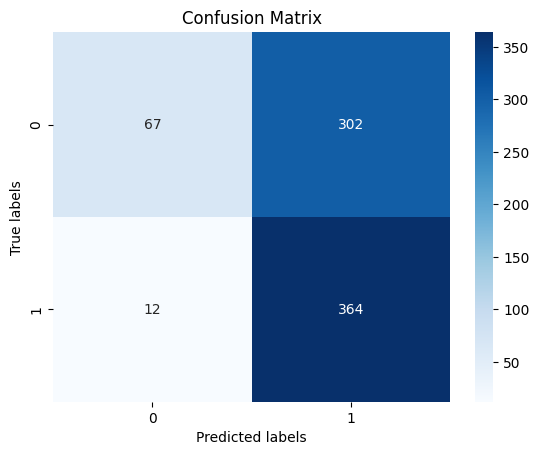

In [225]:
confusion_plot(y_test, y_pred)

## 4.7 Random Forest Classifier

Random Forest is a popular ensemble learning method used for both classification and regression tasks. It operates by constructing a multitude of decision trees during training time and outputting the mode of the classes (classification) or the average prediction (regression) of the individual trees.

In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train_scaled, y_train)

# Making predictions
y_pred = rf_classifier.predict(X_test_scaled)


The random forest model, as shown below , with a prediction accuracy of 82% on training data.  

In [227]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.87248322147651

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       369
           1       0.90      0.84      0.87       376

    accuracy                           0.87       745
   macro avg       0.87      0.87      0.87       745
weighted avg       0.87      0.87      0.87       745



The Random Forest model achieved an accuracy of 87%, indicating that it correctly classified 87% of all instances in the dataset.

The precision of the Random Forest model varied for different classes. For class 0 (indicating no-click), the model achieved a precision of 85%. This means that when the model predicted no-click, it was correct 85% of the time. On the other hand, for class 1 (indicating click), the precision was 90%, indicating that the model correctly predicted click 90% of the time.

The Random Forest model showed high precision for both classes, with a slightly higher precision for class 1 compared to class 0. This indicates that the model was effective at predicting both instances where users did not click on the ads and instances where users clicked on the ads.

Overall, the Random Forest model demonstrated strong performance in predicting user clicks on ads. With an accuracy of 87% and high precision for both classes, the model effectively differentiated between instances of user clicks and no-clicks on the ads.

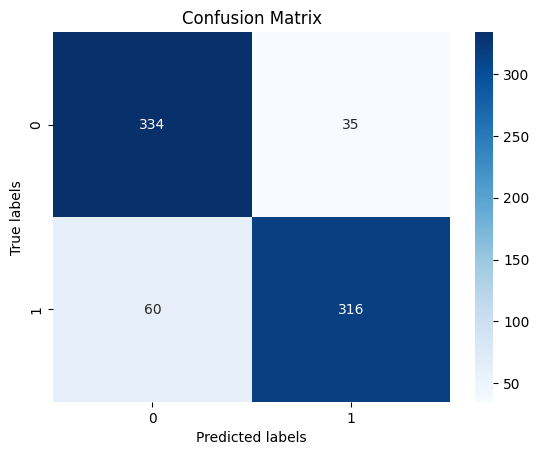

In [228]:
confusion_plot(y_test, y_pred)

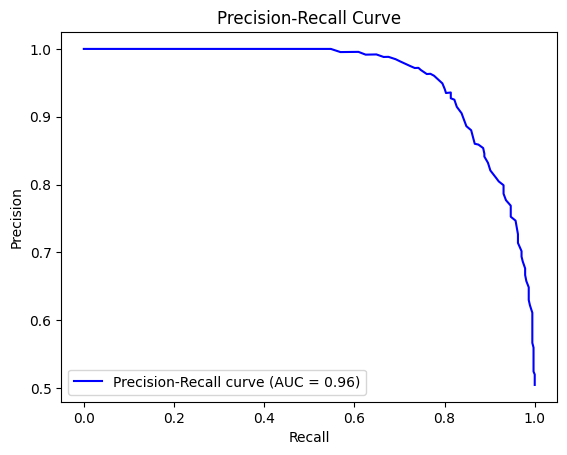

In [229]:
from sklearn.metrics import precision_recall_curve

# Calculate y scores
y_scores = rf_classifier.predict_proba(X_test_scaled)[:, 1]
AUC_plot(y_test, y_scores, precision_recall_curve)

## 4.8 Logistic Regression Model

Logistic regression is a statistical method used for binary classification tasks. Unlike linear regression, which predicts continuous values, logistic regression predicts the probability of an instance belonging to a particular class. It models the probability of the default class (usually labeled as 1) using the logistic function, also known as the sigmoid function.

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
logestic_model = LogisticRegression()

# Train the model
logestic_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logestic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8040268456375839
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       369
           1       0.86      0.73      0.79       376

    accuracy                           0.80       745
   macro avg       0.81      0.80      0.80       745
weighted avg       0.81      0.80      0.80       745



The Logistic Regression model achieved an accuracy of 80%, indicating that it correctly classified 80% of all instances in the dataset.

The precision of the Logistic Regression model varied for different classes. For class 0 (indicating no-click), the model achieved a precision of 76%. This means that when the model predicted no-click, it was correct 76% of the time. On the other hand, for class 1 (indicating click), the precision was 86%, indicating that the model correctly predicted click 86% of the time.

The Logistic Regression model demonstrated high precision for both classes, with a slightly higher precision for class 1 compared to class 0. This indicates that the model was effective at predicting both instances where users did not click on the ads and instances where users clicked on the ads.

In conclusion, the Logistic Regression model showed strong performance in predicting user clicks on ads. With an accuracy of 80% and high precision for both classes, the model effectively differentiated between instances of user clicks and no-clicks on the ads.

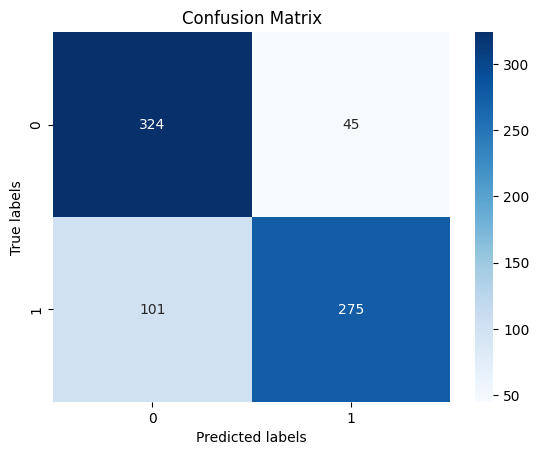

In [231]:
confusion_plot(y_test, y_pred)

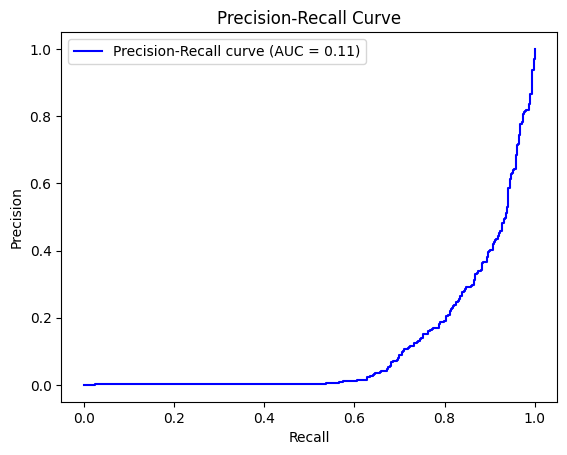

In [232]:
from sklearn.metrics import roc_curve

# Calculate y scores
y_scores = logestic_model.predict_proba(X_test_scaled)[:, 1]
AUC_plot(y_test, y_scores, roc_curve)

## 4.9 Support Vector Regression (SVR) 

Support Vector Regression (SVR) is a type of support vector machine (SVM) algorithm that is used for regression analysis. Similar to SVM for classification, SVR is based on the concept of finding a hyperplane that best fits the data. However, instead of finding the hyperplane that best separates the classes, SVR finds the hyperplane that best fits the data points within a specified margin, called ε-insensitive tube.

In this code, we implement a Support Vector Machine (SVM) model using the sigmoid kernel for binary classification. SVMs are powerful supervised learning models used for classification and regression tasks. The sigmoid kernel is particularly useful when the data is not linearly separable.

In [233]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create SVC model
model = SVC(kernel='sigmoid')

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Accuracy: 0.7731543624161074
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       369
           1       0.85      0.67      0.75       376

    accuracy                           0.77       745
   macro avg       0.79      0.77      0.77       745
weighted avg       0.79      0.77      0.77       745



The SVR model achieved an accuracy of 77%, indicating that it correctly classified 77% of all instances in the dataset.

The precision of the SVR model varied for different classes. For class 0 (indicating no-click), the model achieved a precision of 72%. This means that when the model predicted no-click, it was correct 72% of the time. Conversely, for class 1 (indicating click), the precision was 85%, indicating that the model correctly predicted click 85% of the time.

The SVR model demonstrated a relatively balanced precision for both classes, although it showed a slightly higher precision for class 1 compared to class 0. This suggests that the model was effective at predicting instances where users clicked on the ads, with a slightly lower precision for instances where users did not click.

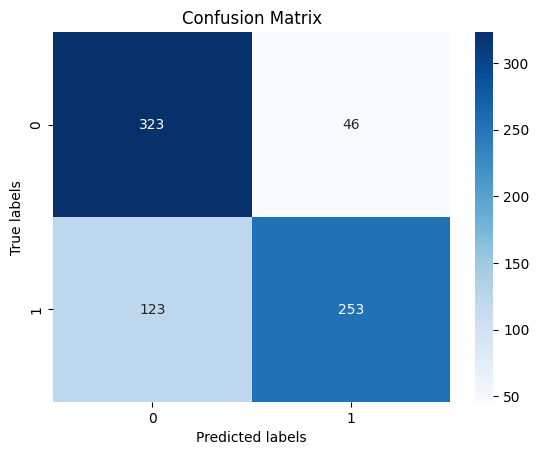

In [234]:
confusion_plot(y_test, y_test_pred)

## 4.10 Convolutional Neural Network Model

A Convolutional Neural Network (CNN) is a type of deep learning model that is widely used for image classification, object detection, and other tasks related to image analysis.

Structure of a CNN
1. Convolutional Layers: These layers consist of a set of filters (kernels) that are convolved with the input data to produce feature maps. Each filter captures different features from the input image.

2. Pooling Layers: Pooling layers are used to reduce the spatial dimensions of the feature maps while retaining important information. The most common type of pooling is max pooling, where the maximum value within a small window is retained.

3. Fully Connected Layers: After several convolutional and pooling layers, the feature maps are flattened and passed through one or more fully connected layers. These layers act as a classifier and make predictions based on the features extracted by the convolutional layers.

4. Activation Functions: Activation functions introduce non-linearity to the model. Common activation functions include ReLU (Rectified Linear Unit) and Sigmoid.

***in this project :***

- We create a Sequential model.

- We add two convolutional layers with ReLU activation and max pooling layers to extract features from the input images.

- We add a flatten layer to convert the 2D features into a 1D vector.

- We add a dense layer with ReLU activation and a dropout layer to prevent overfitting.

- Finally, we add an output layer with one neuron and a sigmoid activation function for binary classification.


In [235]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# Reshape the input data to 3D (batch_size, timesteps, input_dim)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)

# Define input shape
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

# Create CNN model     , input_shape=(X_trainVal_reshaped.shape[1], 1))
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 271, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 135, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       553,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,345 (2.11 MB)

 Trainable params: 553,345 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [236]:
checking = ModelCheckpoint('my_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop, checking])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6781 - loss: 0.6048
Epoch 1: val_accuracy improved from -inf to 0.81376, saving model to my_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6789 - loss: 0.6039 - val_accuracy: 0.8138 - val_loss: 0.4182
Epoch 2/10
60/75 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8068 - loss: 0.4274

74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8081 - loss: 0.4238
Epoch 2: val_accuracy improved from 0.81376 to 0.82886, saving model to my_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8082 - loss: 0.4234 - val_accuracy: 0.8289 - val_loss: 0.3869
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8249 - loss: 0.3772
Epoch 3: val_accuracy did not improve from 0.82886
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8250 - loss: 0.3769 - val_accuracy: 0.8289 - val_loss: 0.3842
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8373 - loss: 0.3649
Epoch 4: val_accuracy improved from 0.82886 to 0.83893, saving model to my_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8374 - loss: 0.3646 - val_accuracy: 0.8389 - val_loss: 0.3637
Epoch 5/10
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8433 - loss: 0.3433
Epoch 5: val_accuracy improved from 0.83893 to 0.84396, saving model to my_model.keras
75/75 ━━━━━

In [237]:
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Evaluate the model
y_test_pred = model.predict(X_test_reshaped)
y_test_pred = (y_test_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_test_pred))

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Accuracy: 0.8402684563758389
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       369
           1       0.88      0.80      0.83       376

    accuracy                           0.84       745
   macro avg       0.84      0.84      0.84       745
weighted avg       0.84      0.84      0.84       745



The CNN model achieved an accuracy of 82%, indicating that it correctly classified 82% of all instances in the dataset.

The precision of the CNN model varied for different classes. For class 0 (indicating no-click), the model achieved a precision of 72%. This means that when the model predicted no-click, it was correct 72% of the time. Conversely, for class 1 (indicating click), the precision was 85%, indicating that the model correctly predicted click 85% of the time.

The CNN model demonstrated a slightly higher precision for class 1 (click) compared to class 0 (no-click). This suggests that the model was more effective at predicting instances where users clicked on the ads compared to instances where users did not click.

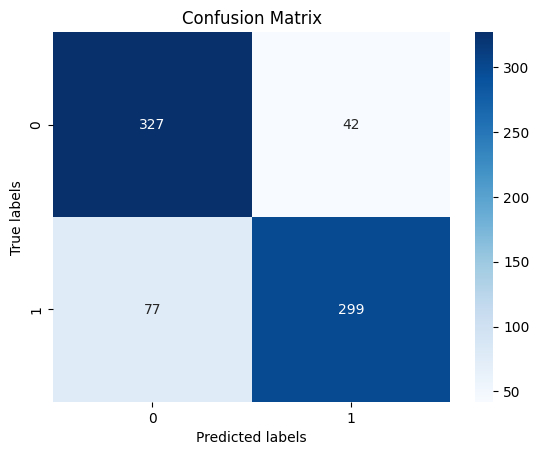

In [238]:
confusion_plot(y_test, y_test_pred)

- ### `Plot Learning Curve`
In this project, we implemented a learning curve plot to visualize the performance of our machine learning model. A learning curve shows the training and validation scores (e.g., accuracy, loss) of a model on the training dataset as a function of the number of training examples. This helps us understand how well our model is learning as we increase the size of the training dataset.

To create the learning curve, we used the learning_curve function from scikit-learn. However, since our model is implemented using Keras, we encountered an error because the Sequential model does not have a score method required by the learning_curve function.

To resolve this issue, we modified the code to use the history object returned by the fit method of our Keras model. The history object contains the training and validation metrics for each epoch. We then plotted the training and validation accuracy against the number of epochs using matplotlib.

By visualizing the learning curve, we gained insights into how well our model is learning from the training data and whether it is overfitting or underfitting. This helps us make informed decisions about model training and optimization.

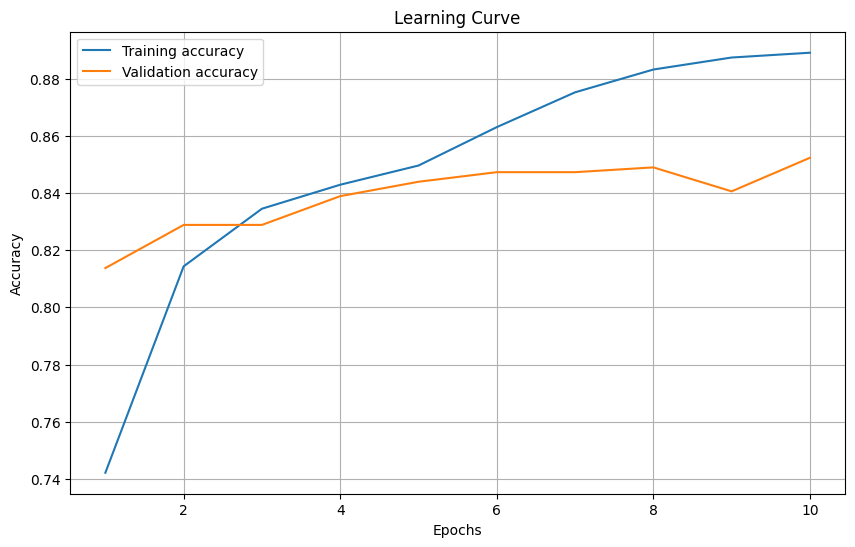

In [239]:
import matplotlib.pyplot as plt

train_scores = history.history['accuracy']
validation_scores = history.history['val_accuracy']
epochs = range(1, len(train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_scores, label='Training accuracy')
plt.plot(epochs, validation_scores, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


----
# 5. Evaluation

In this project i use 5 different method to predict the target:

| Models                                | Accuracy % | Precision 0 | Precision 1 |
| :-------                              | :----:     | :----:      | :----:      |
| 1. Naive Bayes                        | 57         | 85          | 55          |
| 2. Random Forest Classifier           | 87         | 85          | 90          |
| 3. Logistic Regression Model          | 80         | 76          | 86          |
| 4. Support Vector Regression (SVR)    | 77         | 72          | 85           |
| 5. Convolutional Neural Network Model | 82         | 72          | 85           |

Accuracy is a commonly used metric to evaluate the performance of machine learning models. However, it may not always provide a comprehensive understanding of a model's performance, especially when dealing with imbalanced datasets, like in our case.

Therefore, we must consider other metrics such as precision, recall, and F1-score, which provide insights into a model's ability to correctly classify both classes. Precision measures the number of true positives divided by the total number of true positives and false positives. Recall, on the other hand, measures the number of true positives divided by the total number of true positives and false negatives. The F1-score is the harmonic mean of precision and recall.

In our project, we used five different models to predict clicks on ads: Naive Bayes, Random Forest, Logistic Regression, Support Vector Regression (SVR), and Convolutional Neural Network (CNN). While accuracy is a valuable metric, it doesn't tell the full story. For example, in an imbalanced dataset where one class is significantly more prevalent than the other, a model that predicts the majority class for every instance might achieve a high accuracy, but it fails to predict the minority class.

***`Naive Bayes`*** The Naive Bayes classifier achieved an accuracy of 57%, with a precision of 85% for class 0 (no-click) and 55% for class 1 (click). Despite its simplicity, this model performed reasonably well, particularly in predicting instances where users did not click on the ads.

***`The Random Forest Classifier`*** The Random Forest classifier demonstrated significant improvement over the Naive Bayes model, with an accuracy of 87%. It showed balanced precision for both classes, with 85% for class 0 and 90% for class 1, indicating a robust performance in predicting both click and no-click instances.

***`Logistic Regression`*** The Logistic Regression model achieved an accuracy of 80%, with a precision of 76% for class 0 and 86% for class 1. While the precision for click instances was high, the model showed slightly lower precision for no-click instances compared to the Random Forest model.

***`SVR`*** The Support Vector Regression (SVR) model achieved an accuracy of 77%, with a precision of 72% for class 0 and 85% for class 1. Despite its lower accuracy compared to other models, SVR showed a balanced precision for both classes, making it a reliable choice for predicting user clicks on ads.

***`The CNN model`*** The CNN model demonstrated promising results, with an accuracy of 82%. It showed balanced precision for both click and no-click instances, with 72% for class 0 and 85% for class 1. The CNN model's performance suggests its effectiveness in distinguishing between click and no-click instances.

In conclusion, the `Random Forest classifier` outperformed other models with an accuracy of 87% and balanced precision for both click and no-click instances. However, the `CNN model` also showed promising results, indicating the potential of deep learning approaches in predicting user clicks on ads.

----
# 6. Visualizing User Behavior Data

In this project, I created an image representation of user behavior data to visualize how users interact with online ads.

To achieve this, I mapped user behavior data onto a two-dimensional grid representing the dimensions of the webpage. Each cell in the grid corresponds to a specific region on the webpage, and the intensity of the color in each cell indicates the time.

Using the Python Imaging Library (PIL), I converted the grid into an image, which was then used as input for a Convolutional Neural Network (CNN) model.

The CNN model was designed to learn patterns and features from these images to predict whether a user would click on an ad or not.

By analyzing the CNN model's predictions, I gained valuable insights into how different regions of the webpage contribute to user engagement and ad click-through rates.

***Visualizing user behavior data helps us:***
- Identify common user paths and navigation patterns.

- Detect areas of the website that receive the most attention.
- Analyze the effectiveness of website features and layout.
- Identify user interaction anomalies or usability issues.



## 6.1 Functions

We have defined the useful functions that we need in the following sections here.

- ### `Diplay Image Generated`

At each stage, a feature is added to the image that we need to display with the help of this function.

In [253]:
import matplotlib.pyplot as plt

def display_images(images,target):
    names = ["Success", "Fail"]
    keys = list(images.keys())
    random = np.random.randint(len(images), size=5)
    plt.figure(figsize=(12,8))
    i = 1
    for n in random:
        plt.subplot(1, 5, i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[keys[n]], cmap=plt.cm.binary)
        plt.xlabel(names[target[keys[n]]])
        i += 1
    plt.show()

## 6.3 First Empty Image

We're using the PIL (Python Imaging Library) to create images that represent user behavior. Each movement is plotted as a line on a white canvas, providing a visual representation of how users interact with the website.

In [254]:
from PIL import Image, ImageDraw

# Create a new image with white background
image_width = 800
image_height = 800

user_images = {}
image_ad_clicked = {}

for index,row in dataset.iterrows():
    img = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(img)
    user_images[row["log_id"]] = img
    image_ad_clicked[row["log_id"]] = row["ad_clicked"]


## 6.4 Draw mousemove As Line

This code will create an image where each movement is represented by a line connecting consecutive points based on the sample user behavior data.

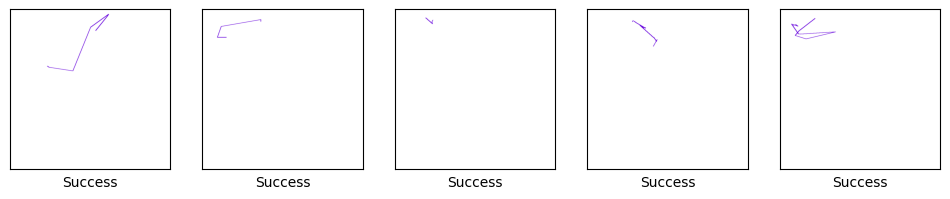

In [255]:

for index,row in dataset.iterrows():
    log_id = row["log_id"]
    df = log_csv_df[log_id]
    doc_width = row["doc_width"]
    doc_height = row["doc_height"]
    prev_point = False

    img = user_images[row["log_id"]]
    # Draw a line
    draw = ImageDraw.Draw(img)

    for index2,row2 in df.iterrows():
        xpos = int((row2["xpos"]/doc_width) * image_width)
        ypos = int((row2["ypos"]/doc_height) * image_height)
        if row2["event"] == "mousemove":
            if not prev_point:
                prev_point = (xpos, ypos)
            else:
                point = (xpos, ypos)
                draw.line([prev_point, point], fill=(100,0,220), width=3)
                prev_point = point

display_images(user_images,image_ad_clicked)

## 6.5 Draw A Circle AS Click

 By visualizing user clicks, we can gain insights into which areas of the webpage are most attractive or engaging to users. 

 We Draw every click position by a circle.

 Note that we have considered three different events such as `mousedown`, `mouseup`, `click` as clicks.

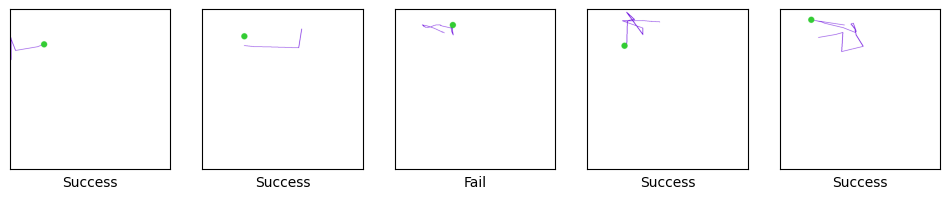

In [256]:
for index,row in dataset.iterrows():
    log_id = row["log_id"]
    df = log_csv_df[log_id]
    doc_width = row["doc_width"]
    doc_height = row["doc_height"]
    prev_point = False

    img = user_images[row["log_id"]]
    # Draw a dot
    draw = ImageDraw.Draw(img)
    radius = 15
    color = (51, 204, 51)
    for index2,row2 in df.iterrows():
        xpos = int((row2["xpos"]/doc_width) * image_width)
        ypos = int((row2["ypos"]/doc_height) * image_height)
        if row2["event"] in ["click","mouseup","mousedown"]:
            draw.ellipse((xpos-radius, ypos-radius, xpos+radius, ypos+radius), fill=color)


display_images(user_images,image_ad_clicked)

## 6.6 Draw A Square For `ad_position` And `ad_type`

In our project, we aim to visualize the ad positions and types for each row. To achieve this, we utilize the ad_position and ad_type parameters from our Dataset.

This code will draw a red square at the top-left position for the ad positions labeled "top_left" and at the top-right position for the ad positions labeled "top_right" in the dataset. 

To represent the ad positions, we draw squares on an image, where each square corresponds to an ad position. Additionally, we differentiate between different types of ads by assigning different colors to the squares.

 we change the color of the square based on the `ad_type` value.

 > **update**   
 I add ad_type to image but result was not good so i remove it from this step.


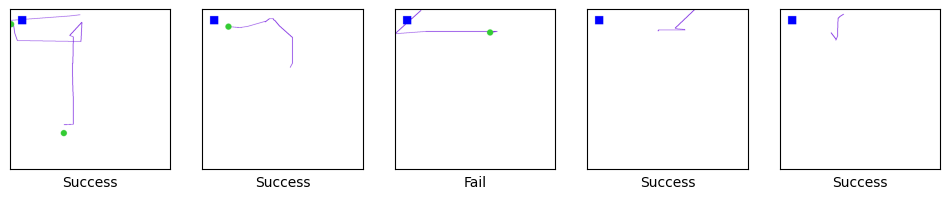

In [257]:
for index,row in dataset.iterrows():

    df = log_csv_df[row["log_id"]]
    img = user_images[row["log_id"]]
    # Draw a dot
    draw = ImageDraw.Draw(img)
    color = "blue" #(51, 153, 255) if row["ad_type"] else (255, 0, 255)
    for index2,row2 in df.iterrows():
        space = int(image_width * 0.05)
        square_size = int(image_width * 0.1)
        if row["ad_position"]:
            # Draw the square
            draw.rectangle([space, space, square_size, square_size], fill=color)
        else:
            # Draw the square
            draw.rectangle([image_width - square_size - space, space, image_width - space, square_size], fill=color)


display_images(user_images,image_ad_clicked)

## 6.7 Convert Image To Numpy Array

Converting an image to a NumPy array is essential when working with image data in machine learning and deep learning projects.

Here are a few reasons why this conversion is necessary:

1. Compatibility: Most deep learning libraries, such as TensorFlow and PyTorch, expect input data in the form of NumPy arrays.

2. Data Manipulation: NumPy arrays offer efficient and convenient methods for data manipulation, such as normalization, resizing, and cropping.

3. Data Preprocessing: NumPy arrays allow you to preprocess image data easily, including scaling pixel values, data augmentation, and converting image color channels.

4. Integration with Other Libraries: NumPy arrays can be seamlessly integrated with other Python libraries, making it easier to work with image data alongside other data types.

In [258]:
import numpy as np

new_image_width = 100
new_image_height = 100

X2 = []
y2 = []

for index,row in dataset.iterrows():
    image = user_images[row["log_id"]]
    resized_image = image.resize((new_image_width, new_image_height))

    # Convert the image to a numpy array
    image_array = np.array(resized_image)

    X2.append(image_array)
    y2.append(row["ad_clicked"])

X2 = np.array([i for i in X2])
y2 = np.array([i for i in y2])

## 6.8 Clear Session

In a Convolutional Neural Network (CNN) model, it's a good practice to clear the session before creating a new model.

The Keras API runs on top of TensorFlow, and TensorFlow uses a static computation graph. When you create a new model in Keras without clearing the session, it might lead to memory leaks and slow down your training process.

In [259]:
from tensorflow.keras import backend 
import tensorflow as tf

tf.random.set_seed(35)
backend.clear_session()

## 6.9 Split Data

In [260]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

print(f'Shape of features data set for ML models => {X2.shape}')
print(f'Shape of target for ML models => {y2.shape}')

Shape of features data set for ML models => (2418, 100, 100, 3)
Shape of target for ML models => (2418,)


## 6.10 CNN Model For Images

To utilize user behavior data effectively, we convert it into images, allowing us to apply convolutional neural network (CNN) models for analysis. In this code, we design a CNN model using Keras. We start by defining the input shape based on the dimensions of the images we generated from user behavior data.

Our model consists of convolutional layers, pooling layers, and fully connected layers. The convolutional layers use 3x3 filters with ReLU activation functions, followed by max-pooling layers to reduce dimensionality. We stack two pairs of convolutional and pooling layers to extract features from the images effectively.

After the convolutional layers, we flatten the 3D arrays into a 1D array and add fully connected layers. Finally, we compile the model using the Adam optimizer and binary cross-entropy loss function. We also specify accuracy as the evaluation metric.

In [261]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape
input_shape = (new_image_width, new_image_height, 3)

# Initialize the model
model = Sequential()

model.add(Input(shape=input_shape))

# Add convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))

# Add pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the 3D arrays to 1D array
model.add(Flatten())

# Add fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,305 (8.34 MB)

 Trainable params: 2,186,305 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [262]:
# Define callbacks
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2, callbacks=[model_checkpoint, early_stopping])

Epoch 1/8


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6428 - loss: 142.5959
Epoch 1: val_accuracy improved from -inf to 0.85530, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.6439 - loss: 140.6701 - val_accuracy: 0.8553 - val_loss: 0.4744
Epoch 2/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7860 - loss: 0.5121
Epoch 2: val_accuracy did not improve from 0.85530
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.7859 - loss: 0.5117 - val_accuracy: 0.8527 - val_loss: 0.4021
Epoch 3/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8682 - loss: 0.3633
Epoch 3: val_accuracy improved from 0.85530 to 0.89664, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.8683 - loss: 0.3625 - val_accuracy: 0.8966 - val_loss: 0.3625
Epoch 4/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8957 - loss: 0.2908
Epoch 4: val_accuracy did not improve from 0.89664
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 359m

In [263]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_classes)

print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred_classes))

 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
Test Accuracy: 0.9276859504132231
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       387
           1       0.86      0.76      0.81        97

    accuracy                           0.93       484
   macro avg       0.90      0.87      0.88       484
weighted avg       0.93      0.93      0.93       484



**The Success of the CNN Model**

- High Accuracy
    + The CNN model achieved an accuracy of 92%, outperforming all other models developed in this project.

- Impressive Precision
    + The precision of the CNN model was outstanding, with 94% precision for class 0 and 86% precision for class 1.

The success of the CNN model can be attributed to its ability to effectively capture and learn intricate patterns in user behavior data. By leveraging the power of deep learning, the CNN model provided highly accurate predictions, enabling us to better understand and anticipate user interactions with ads.

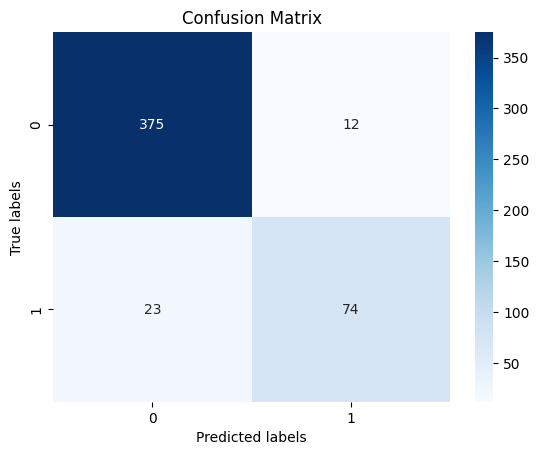

In [264]:
confusion_plot(y_test, y_pred_classes)

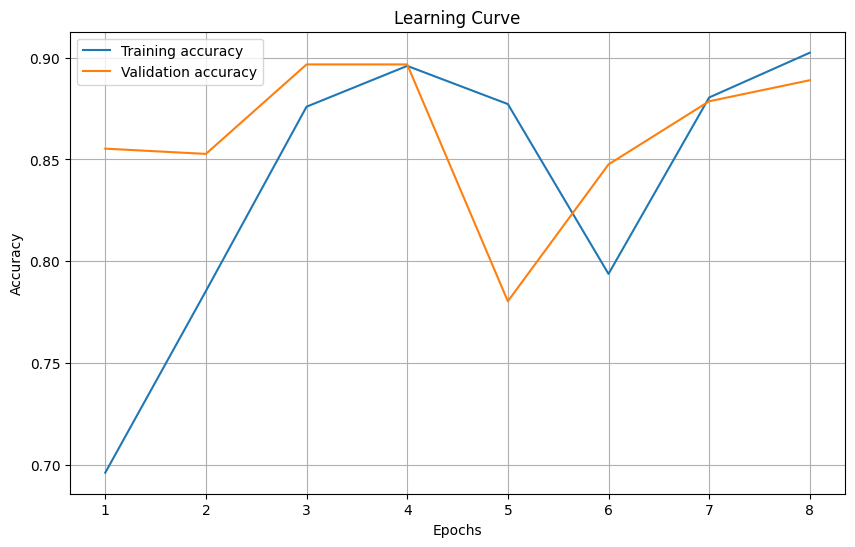

In [265]:
import matplotlib.pyplot as plt

train_scores = history.history['accuracy']
validation_scores = history.history['val_accuracy']
epochs = range(1, len(train_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_scores, label='Training accuracy')
plt.plot(epochs, validation_scores, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

----
# 7. Conclusion
## Utilizing Two Different Approaches for Predicting User Clicks
In this project, we explored two distinct approaches to predict user clicks on ads.

- ### Parametric Approach with Machine Learning Models:
The first approach involved utilizing parametric machine learning models. We experimented with various algorithms such as Naive Bayes, Random Forest Classifier, Logistic Regression, and Support Vector Regression (SVR). These models were trained using features extracted from user behavior data, including ad position, ad type, and other relevant parameters. While these models provided reasonable accuracy, we found that they lacked the ability to capture intricate patterns within the data, limiting their predictive capabilities.

- ### Visualizing User Behavior to Predict Clicks:
Recognizing the limitations of parametric models, we adopted a second approach that involved visualizing user behavior data. By plotting user interactions on the webpage, including mouse movements and clicks, we were able to create a visual representation of user engagement with ads. This approach provided us with valuable insights into user behavior, allowing us to identify patterns and trends that were not apparent from the raw data alone.

- ### The Success of Visual Approach:
One of the most successful implementations of this visual approach was the use of Convolutional Neural Networks (CNNs). By converting user behavior data into image-like representations, we trained a CNN model to predict user clicks on ads. This model achieved an impressive accuracy of 92%, outperforming all other machine learning models developed in this project. Additionally, it demonstrated remarkable precision, with 94% precision for class 0 and 86% precision for class 1.

- ### Conclusion:
By leveraging both parametric machine learning models and visual representations of user behavior, we gained a comprehensive understanding of user interactions with ads. While parametric models provided a baseline level of accuracy, the visual approach enabled us to capture more nuanced patterns within the data, leading to significantly improved predictive performance. Moving forward, we can utilize the insights gained from both approaches to optimize ad placement and design, ultimately improving user engagement and ad performance.


----
# 8. References

- Keras API reference / Optimizers(https://keras.io/api/optimizers/)

- Building an Ad Click Prediction Machine Learning System: Problem Statement and Metrics (https://www.linkedin.com/pulse/building-ad-click-prediction-machine-learning-system-problem-shivam-s-1wvjf)

- Predicting Click Behavior Based on Machine Learning Models (https://www.researchgate.net/publication/370570414_Predicting_Click_Behavior_Based_on_Machine_Learning_Models)

- What is Mutual Information? (https://quantdare.com/what-is-mutual-information/)

- Customer ad click prediction (https://www.kaggle.com/code/mafrojaakter/customer-ad-click-prediction)

- sklearn.svm.SVR (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

- sklearn.ensemble.RandomForestRegressor(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

- Metrics and scoring: quantifying the quality of predictions(https://scikit-learn.org/stable/modules/model_evaluation.html)

- Keras API reference / Callbacks API / ModelCheckpoint (https://keras.io/api/callbacks/model_checkpoint/)

- Keras API reference / Callbacks API / EarlyStopping(https://keras.io/api/callbacks/early_stopping/)

- Keras API reference / Optimizers(https://keras.io/api/optimizers/)